In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# jax
import jax.numpy as jnp
import time

import sys
import os

path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

import statsmodels.api as sm
from data_generation import generate_ode_data

path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_utils_training'))
if path_ not in sys.path:
    sys.path.append(path_)

import run_train_pyomo_rl

In [3]:
import importlib
import nn_pyomo_admm

#importlib.reload(nn_pyomo_admm)
#NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

def reload_module(module_name, class_name):
    module = importlib.import_module(module_name)
    importlib.reload(module)
    return getattr(module, class_name)

In [59]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb_1, y_vdp_cheb_1, y_noisy_vdp_cheb_1, true_derivatives_vdp_cheb_1 = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp_cheb_1 = np.array(jnp.squeeze(y_noisy_vdp_cheb_1))
t_vdp_cheb_1 = np.array(jnp.squeeze(t_vdp_cheb_1))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_vdp_cheb_1 = compute_weights(t_vdp_cheb_1)
D_vdp_cheb_1 = np.array(lagrange_derivative(t_vdp_cheb_1, weights_vdp_cheb_1))

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
est_der_vdp_cheb_1, est_sol_vdp_cheb_1 = collocate_data(y_noisy_vdp_cheb_1, t_vdp_cheb_1, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [60]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
# redefine the start time and the initial state
start_time, end_time = 15, 30 
initial_state = y_vdp_cheb_1[-1]

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb_2, y_vdp_cheb_2, y_noisy_vdp_cheb_2, true_derivatives_vdp_cheb_2 = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp_cheb_2 = np.array(jnp.squeeze(y_noisy_vdp_cheb_2))
t_vdp_cheb_2 = np.array(jnp.squeeze(t_vdp_cheb_2))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_vdp_cheb_2 = compute_weights(t_vdp_cheb_2)
D_vdp_cheb_2 = np.array(lagrange_derivative(t_vdp_cheb_2, weights_vdp_cheb_2))

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
est_der_vdp_cheb_2, est_sol_vdp_cheb_2 = collocate_data(y_noisy_vdp_cheb_2, t_vdp_cheb_2, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


### Merge Data

In [61]:
ys = np.concatenate([np.atleast_2d(y_noisy_vdp_cheb_1[:, 0]), np.atleast_2d(y_noisy_vdp_cheb_2[:, 0])], axis = 1).T
ts = np.concatenate([t_vdp_cheb_1, t_vdp_cheb_2])
Xs = np.concatenate([np.atleast_2d(y_noisy_vdp_cheb_1[:, 1]), np.atleast_2d(y_noisy_vdp_cheb_2[:, 1])], axis = 1).T
y_est = np.concatenate([est_sol_vdp_cheb_1[0], est_sol_vdp_cheb_2[0]])
Ds = [D_vdp_cheb_1, D_vdp_cheb_2]

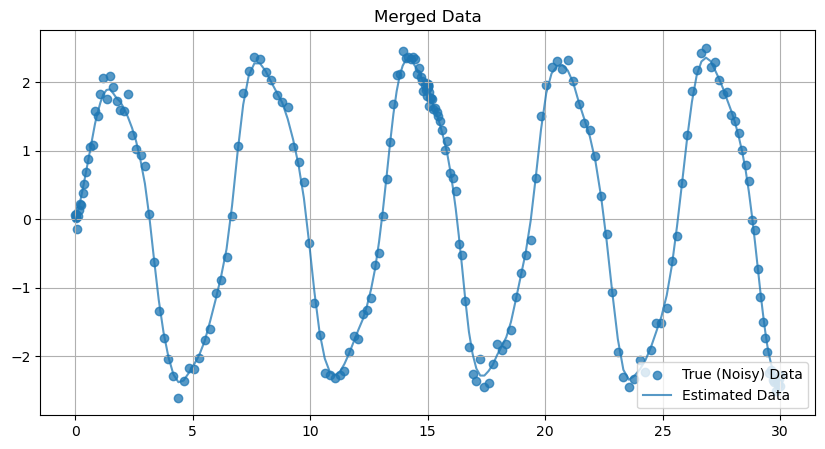

In [65]:
plt.figure(figsize=(10, 5))
plt.scatter(ts, ys, label='True (Noisy) Data', alpha = 0.75)
# plt.plot(ts, Xs, label='True (Noisy) Data - aux', alpha = 0.75)
plt.plot(ts, y_est, label='Estimated Data', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

In [64]:
import nn_pyomo_admm
importlib.reload(nn_pyomo_admm)
NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

tol = 1e-7
params = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 1, "max_iter": 500}

layer_sizes = [2, 20, 1]

ode_model = NeuralODEPyomoADMM(y_observed = ys, 
                        t = ts, # t
                        first_derivative_matrix = Ds, # derivative matrix
                        extra_input = Xs, # extra inputs
                        y_init = y_est,
                        layer_sizes = layer_sizes, act_func = "tanh", 
                        penalty_lambda_reg = 0.01, 
                        rho = 10.0,
                        time_invariant = True,
                        w_init_method = 'xavier', 
                        params = params
                        )

result = ode_model.admm_solve(iterations=100, tol_primal=1e-2)

----------------------------------------------------------------------------------------------------
ADMM Iteration 1/100; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
halt_on_ampl_error=yes
print_level=1
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
halt_on_ampl_error=yes
print_level=1
max_iter=500


******************************************************************************
This program contains Ipopt, a li

----
----

### `Single Model Experiments`

In [245]:
from datetime import datetime, timedelta

start_date = '2015-01-10'
def generate_dates(start_date, sequence_len = 5, frequency = 2):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    date_sequences = [start_date + timedelta(days=i*frequency) for i in range(sequence_len)]
    date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
    return date_sequences_str

def prepare_data(start_date, file_path, encoding):
    data_preprocessor = reload_module('preprocess', 'DataPreprocessor')(file_path, start_date=start_date, number_of_points=300, n_days=1, m=1, feature_encoding=encoding, split=150)
    data_subsample = data_preprocessor.load_data()
    return data_preprocessor.preprocess_data(data_subsample)


['2015-01-20', '2015-01-25', '2015-01-30', '2015-02-04', '2015-02-09', '2015-02-14', '2015-02-19', '2015-02-24', '2015-03-01', '2015-03-06']


In [ ]:
# Constants and Configurations
PENALTY = 0.00001
#PENALTY = 0.01
LAYER_SIZES = [7, 32, 1]
tol = 1e-8
params = {
    "tol": tol,
    "dual_inf_tol": tol,
    "compl_inf_tol": tol,
    "constr_viol_tol": tol,
    "halt_on_ampl_error": 'yes',
    "print_level": 5,
    "max_iter": 500
}
LAYER_SIZES = [7, 40, 1]
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

date_sequences_str = generate_dates(start_date, sequence_len = 5, frequency = 5)

In [253]:
DataPreprocessor = reload_module('preprocess', 'DataPreprocessor')
NeuralODEPyomoADMM = reload_module('nn_pyomo_admm', 'NeuralODEPyomoADMM')

results = {}
for start_date in date_sequences_str:
    df_train_1, df_test_1 = prepare_data(start_date, file_path, encoding)
    end_date = str(df_train_1.index[-1].date())  # Assuming index is datetime
    df_train_2, df_test_2 = prepare_data(end_date, file_path, encoding)

    # Shift time
    shift = df_train_2['t'].max() - df_train_2['t'].min()
    df_train_2['t'] += shift
    df_test_2['t'] += shift

    # Concatenate data
    ys = np.concatenate([df_train_1['y'].values[:, None], df_train_2['y'].values[:, None]], axis=0)
    ts = np.concatenate([df_train_1['t'], df_train_2['t']])
    Xs = np.concatenate([df_train_1.drop(columns=['y', 't']).values, df_train_2.drop(columns=['y', 't']).values], axis=0)

    # Check if we need to recompute the derivatives
    reload_derivatives = False  # Define your condition here
    if reload_derivatives:
        weights_1 = compute_weights(df_train_1['t'])
        D_1 = np.array(lagrange_derivative(df_train_1['t'], weights_1))
        weights_2 = compute_weights(df_train_2['t'])
        D_2 = np.array(lagrange_derivative(df_train_2['t'], weights_2))
        Ds = [D_1, D_2]

    # Model and solve
    ode_model = NeuralODEPyomoADMM(
        y_observed=ys, t=ts, first_derivative_matrix=Ds,
        extra_input=Xs, y_init=ys, layer_sizes=LAYER_SIZES,
        act_func="tanh", penalty_lambda_reg=PENALTY, rho=1.0,
        time_invariant=True, w_init_method='xavier', params=params
    )

    result = ode_model.admm_solve(iterations=30, tol_primal=1e-2, record=True)
    results[start_date] = result

{'result': {'solver_time': 30.985588788986206,
  'termination_condition': <TerminationCondition.optimal: 'optimal'>,
  'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'},
 'times_elapsed': 30.985588788986206,
 'mae_odeint': 0.7155773362832758,
 'mse_odeint': 0.7683638144397044,
 'mae_coll_ode': 1.023454786164931,
 'mse_coll_ode': 1.448038443246539,
 'mae_odeint_test': 1.3088827614418097,
 'mse_odeint_test': 2.471785877563882,
 'mae_coll_ode_test': 1.067399621640494,
 'mse_coll_ode_test': 1.6244789744842145}

In [162]:
results.keys()

dict_keys(['2015-01-20', '2015-01-25', '2015-01-30', '2015-02-04', '2015-02-09', '2015-02-14', '2015-02-19', '2015-02-24', '2015-03-01', '2015-03-06'])

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_12538/822772768.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


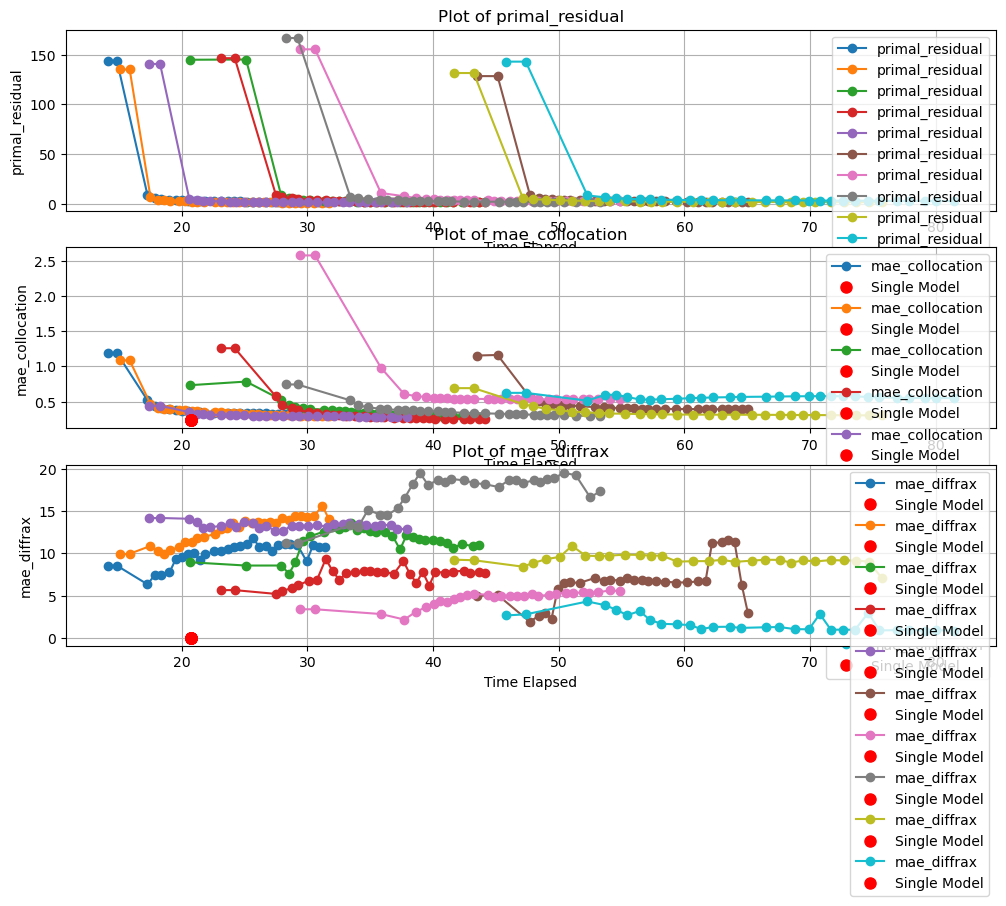

In [164]:
plt.figure(figsize=(12, 8))

columns = ['primal_residual', 'mae_collocation', 'mae_diffrax']

for date in results:
    pos = 0
    result = results[date]
    for key in result:
        if key != 'iter':
            
            if key not in columns:
                continue
            
            pos+=1
            plt.subplot(len(columns), 1, pos)
            plt.plot(result['time_elapsed'], result[key], label=key, marker='o')
            
            if key == 'mae_collocation':
                plt.plot(experiment_results['times_elapsed'], experiment_results['mae_coll_ode'], 
                        'o', color='r', label='Single Model', markersize=8)
            elif key == 'mae_diffrax':
                plt.plot(experiment_results['times_elapsed'], experiment_results['mae_odeint'], 
                        'o', color='r', label='Single Model', markersize=8)
            plt.title(f'Plot of {key}')
            plt.xlabel('Time Elapsed')
            plt.ylabel(key)
            plt.grid(True)
            plt.legend()

plt.tight_layout()
plt.show()

In [150]:
M = 150

tol = 1e-3
params = {"tol":tol, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 100 }

initial_state, t, D, extra_input = ys[0][0], np.array(ts[:M]), D_1, np.array(Xs[M:])
y_solution_1 = ode_model.node_collocation_pred(initial_state, t, D, extra_input)

initial_state, t, D, extra_input = ys[M][0], np.array(ts[M:]), D_2, np.array(Xs[M:])
y_solution_2 = ode_model.node_collocation_pred(initial_state, t, D, extra_input)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    11325

Total number of variables............................:      151
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      151
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number

In [151]:
initial_state, t, extra_input = jnp.array(ys[0]), jnp.array(ts[:M]), (jnp.array(Xs[:M]), jnp.array(ts[:M]))
y_sol_1_diffrax = ode_model.node_diffrax_pred(initial_state, t, extra_input)

initial_state, t, extra_input = jnp.array(ys[M]), jnp.array(ts[M:]), (jnp.array(Xs[M:]), jnp.array(ts[M:]))
y_sol_2_diffrax = ode_model.node_diffrax_pred(initial_state, t, extra_input)

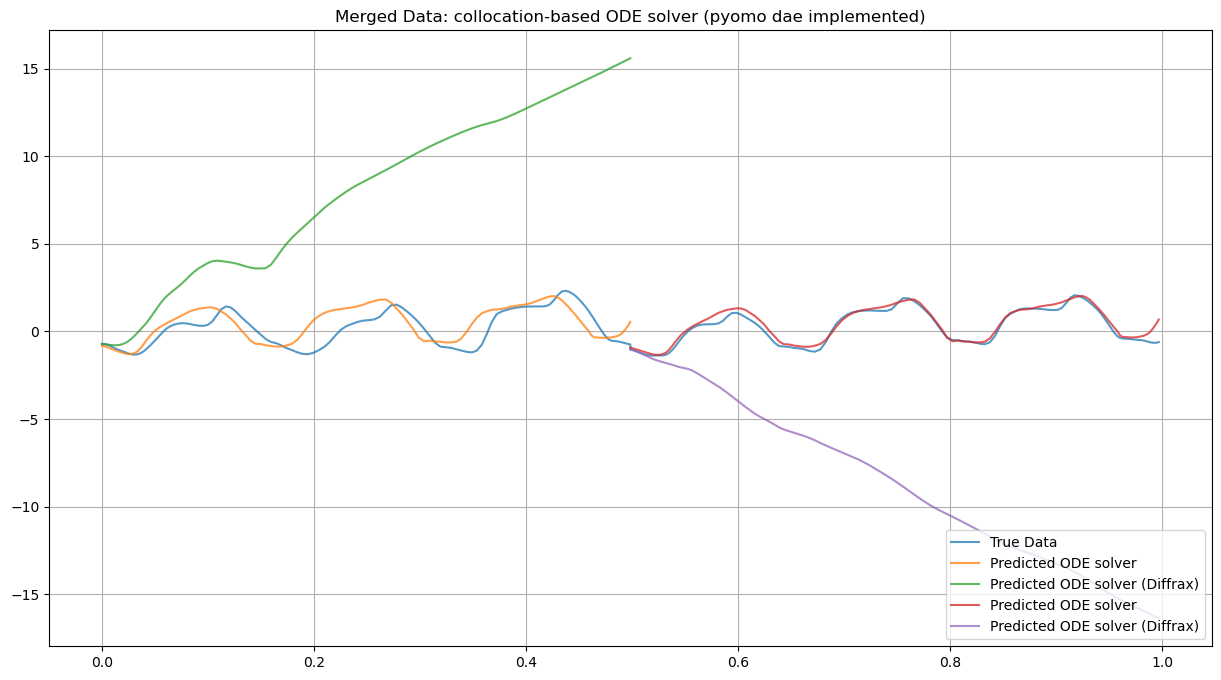

In [152]:
plt.figure(figsize=(15, 8))
plt.plot(ts, ys, label='True Data', alpha = 0.75)
plt.plot(ts[:M], y_solution_1, label='Predicted ODE solver', alpha = 0.75)
plt.plot(ts[:M], y_sol_1_diffrax, label='Predicted ODE solver (Diffrax)', alpha = 0.75)
plt.plot(ts[M:], y_solution_2, label='Predicted ODE solver', alpha = 0.75)
plt.plot(ts[M:], y_sol_2_diffrax, label='Predicted ODE solver (Diffrax)', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data: collocation-based ODE solver (pyomo dae implemented)")
plt.show()